## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer

from sklearn import metrics

pd.set_option("display.max_colwidth", None)

### Load Dataset

In [2]:
train_path = "../data/cleaned_dataset.csv"

In [3]:
# Load dataset and make a datframe based on that
df = pd.read_csv(train_path).drop("Unnamed: 0", axis=1)

In [4]:
# Get some basic information of our dataframe
print(f"Sample Data :{df.head()}")
print(f"\n--------------------------\n\n Columns : {[i for i in df.columns]}")
print(f"\n--------------------------\n\n Size of the dataset : {df.shape[0]}")
print(f"\n--------------------------\n\n Total number of features : {df.shape[1]}")
print(f"\n--------------------------\n\n Number of numerical features: {df.select_dtypes(include=[int, float]).shape[1]}")
print(f"\n--------------------------\n\n Number of categorical features: {df.select_dtypes(include=[object]).shape[1]}")

Sample Data :    Id        PID  MS SubClass MS Zoning  Lot Area Lot Shape Lot Config  \
0  109  533352170           60        RL     13517       IR1    CulDSac   
1  544  531379050           60        RL     11492       IR1    CulDSac   
2  153  535304180           20        RL      7922       Reg     Inside   
3  318  916386060           60        RL      9802       Reg     Inside   
4  255  906425045           50        RL     14235       IR1     Inside   

  Neighborhood Condition 1 Bldg Type  ... Garage Area  Paved Drive  \
0       Sawyer        RRAe      1Fam  ...       475.0            Y   
1  Sawyer West        Norm      1Fam  ...       559.0            Y   
2   North Ames        Norm      1Fam  ...       246.0            Y   
3   Timberland        Norm      1Fam  ...       400.0            Y   
4  Sawyer West        Norm      1Fam  ...       484.0            N   

   Wood Deck SF  Open Porch SF  Enclosed Porch Screen Porch Mo Sold Yr Sold  \
0             0             44      

In [5]:
# Define numerical values
# We don't need "PID" and "Id" because they can't be considered as impactful features on our target
# We drop "SalePrice" because it's our target and we just want to have our features
num = df.select_dtypes(include = [int, float]).drop(columns=["Id", "PID", "SalePrice"], axis=1)
num.columns

Index(['MS SubClass', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Garage Area',
       'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', 'Screen Porch',
       'Mo Sold', 'Yr Sold'],
      dtype='object')

In [6]:
# Check the relationship between basement variables
print(f"The number of Errors between basement variables: {df.loc[(df['BsmtFin SF 1'] + df['BsmtFin SF 2'] + df['Bsmt Unf SF']) != df['Total Bsmt SF'], : ].shape[0]}")

The number of Errors between basement variables: 0


### Assemble Predictor Features (X) and Target (y) 

In [7]:
# Define X (features)
# We don't need "PID" and "Id" because they can't be considered as impactful features on our target
X = df.select_dtypes(include = [int, float]).drop(columns=["Id", "PID", "SalePrice"], axis=1)

# Define y (target)
y= df["SalePrice"]

print(f"The shape of X -------------- {X.shape}")
print(f"The shape of y -------------- {y.shape}")

The shape of X -------------- (1995, 31)
The shape of y -------------- (1995,)


### Baseline Score

In [8]:
# Instantiate Linear Regression Model
lr = LinearRegression()

In [9]:
# Utilize cross_val_score for getting baseline score
print(f"Our Baseline Score for predicting house pricing is ----------------- {np.mean(cross_val_score(lr, X, y, cv=5))}")

Our Baseline Score for predicting house pricing is ----------------- 0.8742007213715945


### Preprocessing on Categorical Features 
For using categorical features in our model, first we need to transform them into numeric values. In this part we will leverage map and one-hot encode for transforming them.

In [10]:
# Replace values with small numbers to "Other" in categorical variables
df = df.replace({
    "MS Zoning": {"C (all)": "Other", "RH": "Other", "A (agr)": "Other", "I (all)": "Other"},
    "Neighborhood": {"Blueste": "Other", "Greens": "Other", "GrnHill": "Other", "Landmrk": "Other"},
    "Condition 1": {"RRNn": "Other", "RRNe": "Other", "PosA": "Other"},
    "House Style": {"1.5Unf": "Other", "2.5Unf": "Other", "2.5Fin": "Other"},
    "Roof Style": {"Mansard": "Other", "Shed": "Other"},
    "Exterior 1st": {"BrkComm": "Other", "Stone": "Other", "CBlock": "Other", "ImStucc": "Other", "AsphShn": "Other"},
    "Exterior 2nd": {"ImStucc": "Other", "Stone": "Other", "AsphShn": "Other", "CBlock": "Other"},
    "Foundation": {"Stone": "Other", "Wood": "Other", "Slab": "Other"},
    "Electrical": {"FuseP": "Other", "Mix": "Other"},
    "Functional": {"Maj2": "Other", "Sev": "Other", "Sal": "Other"},
    "Sale Type": {"ConLD": "Other", "CWD": "Other", "ConLI": "Other", "ConLw": "Other", "Con": "Other", "Oth": "Other"}    
                })

In [11]:
# Define equivalent values
rate_qual = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}

# Columns for mapping
col_map = ["Exter Qual", "Exter Cond", "Bsmt Qual", "Bsmt Cond", "Heating QC", "Kitchen Qual"]

# Make for loop for executing map on columns
for column in col_map:
    df[column] = df[column].replace(to_replace=rate_qual)

In [12]:
# Map values in Basement Exposure with map function
df["Bsmt Exposure"] = df["Bsmt Exposure"].map({"None": 0, "Mn": 1, "Av": 2, "Gd":3})

In [13]:
# Map values in Central Air with map function
df["Central Air"] = df["Central Air"].map({"Y": 1, "N": 0})

In [14]:
# Check the remaining categorical features
df.select_dtypes(include="object").columns

Index(['MS Zoning', 'Lot Shape', 'Lot Config', 'Neighborhood', 'Condition 1',
       'Bldg Type', 'House Style', 'Roof Style', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'BsmtFin Type 1',
       'BsmtFin Type 2', 'Electrical', 'Garage Type', 'Garage Finish',
       'Paved Drive', 'Sale Type'],
      dtype='object')

In [15]:
# Dummify all remaining categorical features
df_allnum = pd.get_dummies(df, drop_first=True)

print(f"number of all features after preprocessing: {df_allnum.shape[1]}")

number of all features after preprocessing: 151


In [16]:
# Save the preprocessed numerical dataset
df_allnum.to_csv("../data/preprocessed_dataset.csv")

#### Correlation between all features and target after preprocessing on categorical features

In [17]:
# correlation of target (SalePrice) with it's predictors 
saleprice_corr = df_allnum.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False)

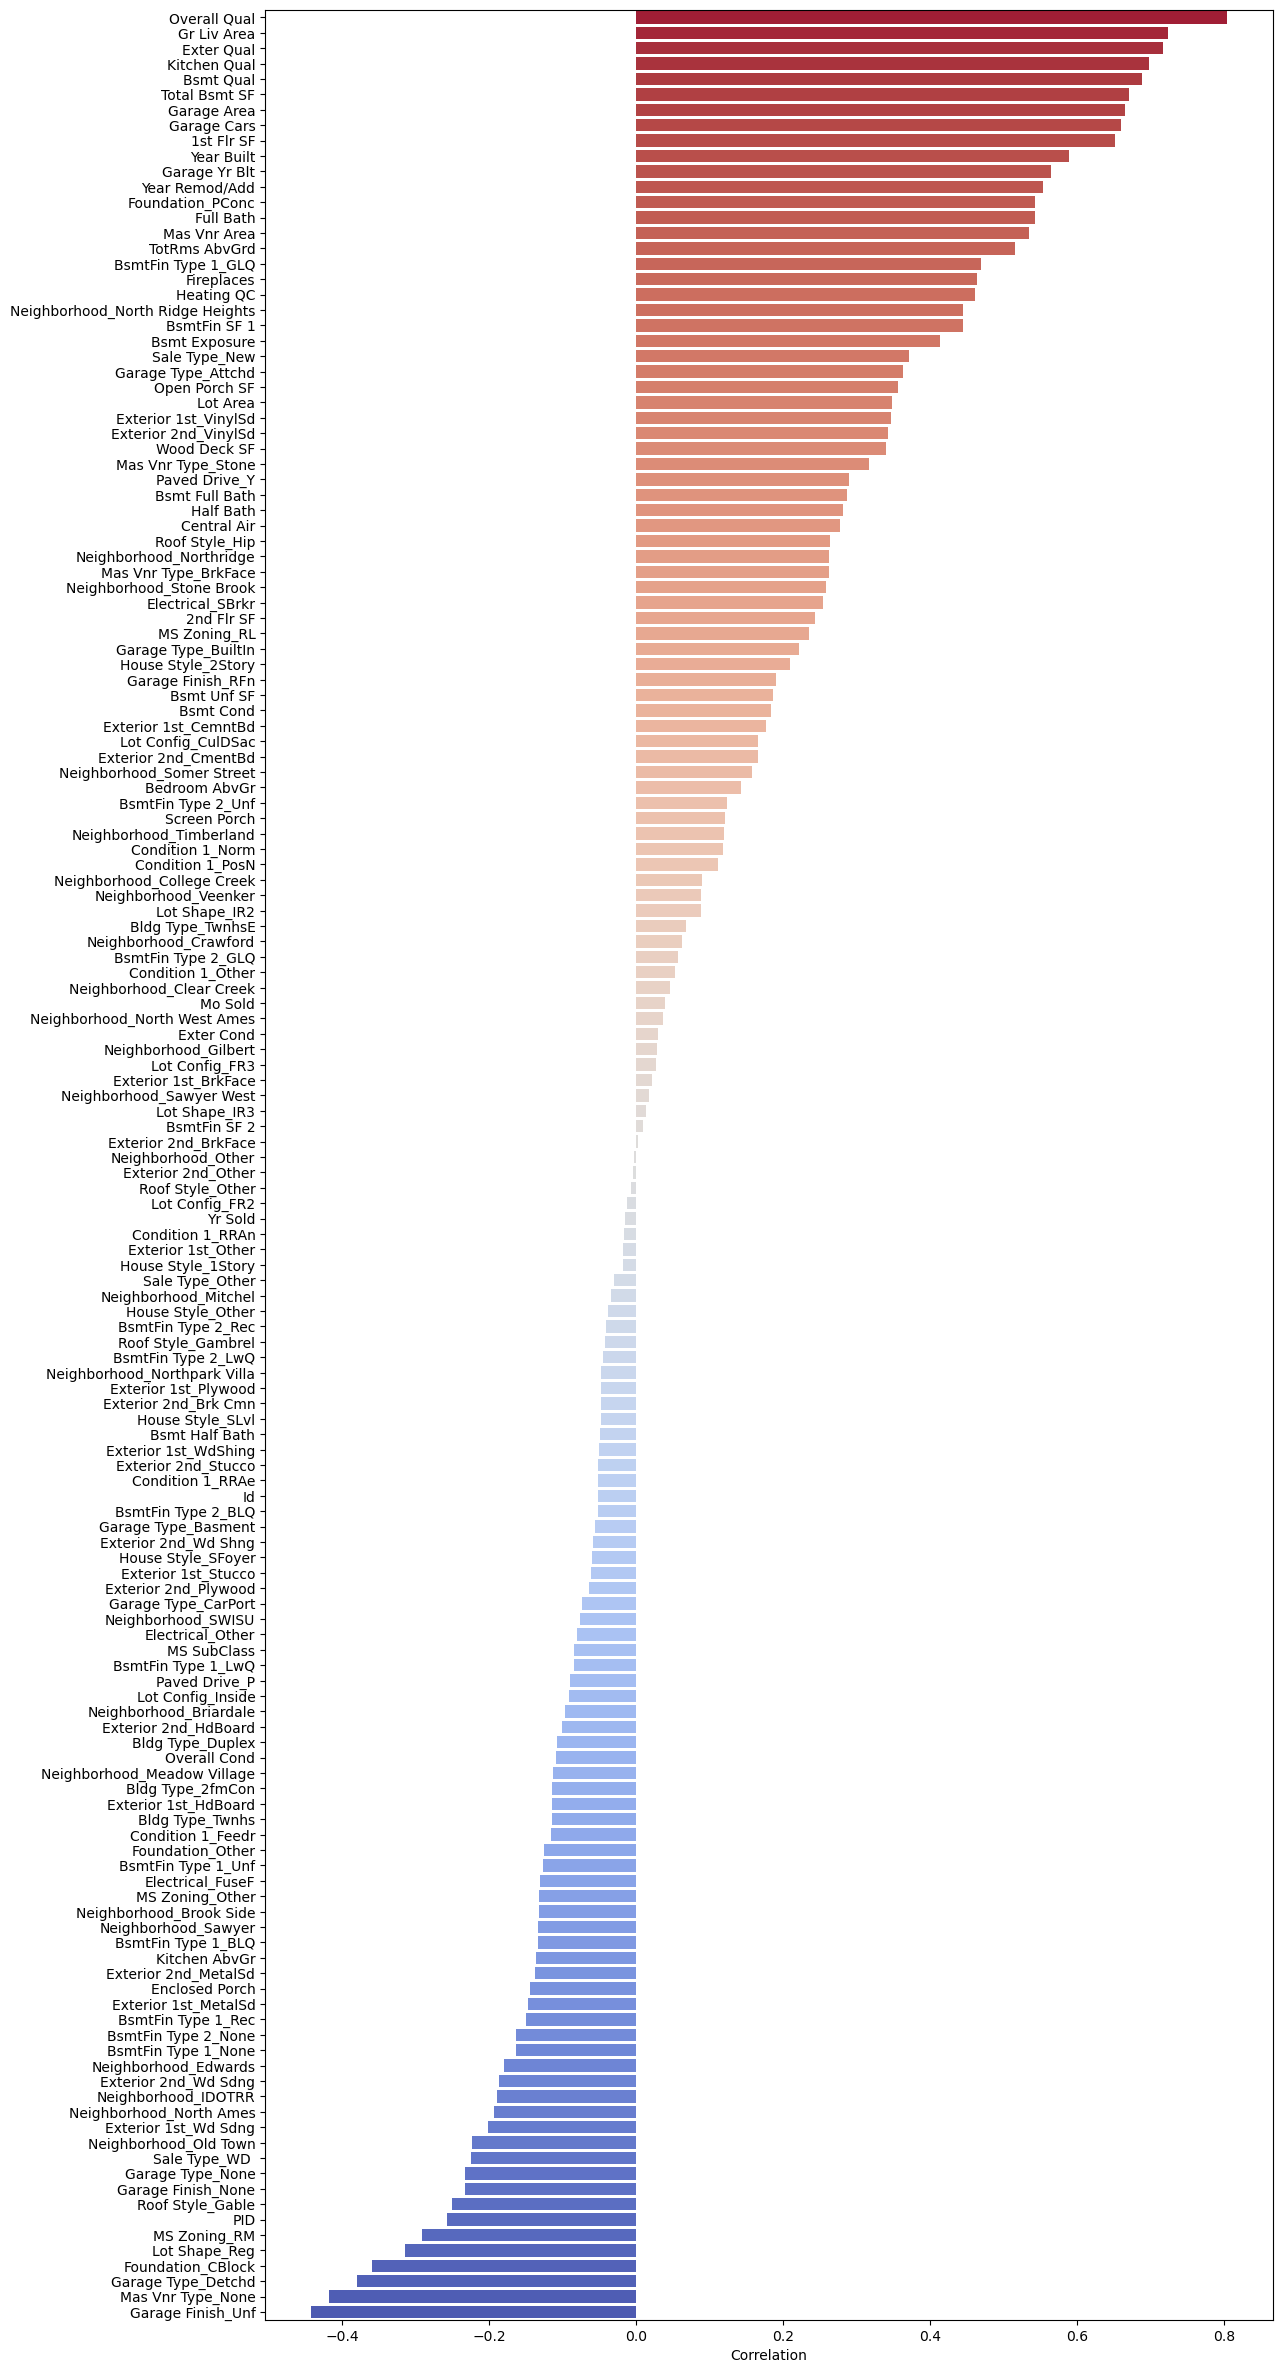

In [18]:
# Plot the correlation of all numerical features with target after preprocessing
palette_reverse = sns.color_palette("coolwarm", n_colors=saleprice_corr.shape[0]-1)
palette_reverse.reverse()

plt.figure(figsize=(13, 30))
sns.barplot(x=saleprice_corr["SalePrice"][1:].values,
           y=saleprice_corr["SalePrice"][1:].index,
           palette=palette_reverse);
plt.title("")
plt.xlabel("Correlation");

#plt.subplots_adjust(left=0.4, right=0.9, top=0.95, bottom=0.05)

# Maximize the plot window
#manager = plt.get_current_fig_manager()
#manager.window.showMaximized()

# Display the plot
#plt.show()

## Modeling After Preprocessing

In [19]:
# Define X (features)
# We don't need "PID" and "Id" because they can't be considered as impactful features on our target 
X = df_allnum.drop(columns=["Id", "PID", "SalePrice"], axis=1)
y = df_allnum["SalePrice"]

print(f"The shape of X -------------- {X.shape}")
print(f"The shape of y -------------- {y.shape}")

The shape of X -------------- (1995, 148)
The shape of y -------------- (1995,)


### Train-Test Split

In [20]:
# Train-Test split on X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [21]:
# Instansiate the model and fit that on train data
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [22]:
# Predit the target based on test data
y_hat = model.predict(X_test)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the model
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Model ".center(34, "="))
print(f"Train R2 score: {model.score(X_train, y_train)}")
print(f"Test R2 score : {model.score(X_test, y_test)}")
print(f"MSE:            {mse}")
print(f"RMSE:           {rmse}")

============= Model ==============
Train R2 score: 0.9333963406647083
Test R2 score : 0.8953553582713911
MSE:            609958514.4025406
RMSE:           24697.338204805405


## Feature Engineering

After cleaning data, doing some preprocessing and making models, here we will do some feature engineering on our features (predictors) to see if we could improve our model performance.

### Make House Area Feature
We have features related to house area, including "Total Bsmt SF"(which is a sum up of "BsmtFin SF 1", "BsmtFin SF 2" and "Bsmt Unf SF"), "1st Flr SF", "2nd Flr SF" and "Gr Liv Area", but we don't have the above ground area and also the whole house area!

In [23]:
# Make a new feature "House Area"
df_allnum["House Area"] = df_allnum["Total Bsmt SF"] + df_allnum["Gr Liv Area"]
print(f"The correlation between 'Total Bsmt SF' and 'SalePrice' ------------------------- {df_allnum['Total Bsmt SF'].corr(df_allnum['SalePrice'])}")
print(f"The correlation between 'Gr Liv Area' and 'SalePrice' --------------------------- {df_allnum['Gr Liv Area'].corr(df_allnum['SalePrice'])}\n")

print(f"The correlation between engineered feature 'House Area' and 'SalePrice' --------- {df_allnum['House Area'].corr(df_allnum['SalePrice'])}")

The correlation between 'Total Bsmt SF' and 'SalePrice' ------------------------- 0.6706729374152067
The correlation between 'Gr Liv Area' and 'SalePrice' --------------------------- 0.7240451560357333

The correlation between engineered feature 'House Area' and 'SalePrice' --------- 0.8302650190311888


### Make Total Bathroom Feature
In our dataset we have Basement full and half bath ("Bsmt Full Bath", "Bsmt Half Bath") and above ground bathroom features including "Full Bath" and "Half Bath". Here we will make 3 other features:
- "Bsmt Full_Half Bath" (which is representing basement total bathrooms)
- "Full_Half Bath" (which is representating above ground total bathrooms)
- "Total Full_Half Bath" (which is representating house total bathrooms)

In [24]:
# Make a new feature as a basement full-half bath which is the sum of basement full bath and basement half bath
df_allnum["Bsmt Full_Half Bath"] = df_allnum["Bsmt Full Bath"] + (df_allnum["Bsmt Half Bath"]/2)

# Make a new feature as above ground full-half bath which is the sum of above ground full bath and above ground half bath 
df_allnum["Full_Half Bath"] = df_allnum["Full Bath"] + (df_allnum["Half Bath"]/2)

# Make a new feature as a total full-half bath which is the sum of basement full-half bath and above ground full-half bath
df_allnum["Total Full_Half Bath"] = df_allnum["Bsmt Full_Half Bath"] + df_allnum["Full_Half Bath"]

print(f"The correlation between 'Bsmt Full Bath' and 'SalePrice' ---------------------------------- {df_allnum['Bsmt Full Bath'].corr(df_allnum['SalePrice'])}")
print(f"The correlation between 'Bsmt Half Bath' and 'SalePrice' ---------------------------------- {df_allnum['Bsmt Half Bath'].corr(df_allnum['SalePrice'])}")
print(f"The correlation between 'Full Bath' and 'SalePrice' --------------------------------------- {df_allnum['Full Bath'].corr(df_allnum['SalePrice'])}")
print(f"The correlation between 'Half Bath' and 'SalePrice' --------------------------------------- {df_allnum['Half Bath'].corr(df_allnum['SalePrice'])}\n")
print(f"The correlation between featured engineered 'Bsmt Full_Half Bath'and and 'SalePrice' ------ {df_allnum['Bsmt Full_Half Bath'].corr(df_allnum['SalePrice'])}")
print(f"The correlation between featured engineered 'Full_Half Bath' and 'SalePrice' -------------- {df_allnum['Full_Half Bath'].corr(df_allnum['SalePrice'])}")
print(f"The correlation between featured engineered 'Total Full_Half Bath' and 'SalePrice' -------- {df_allnum['Total Full_Half Bath'].corr(df_allnum['SalePrice'])}")

The correlation between 'Bsmt Full Bath' and 'SalePrice' ---------------------------------- 0.2877003913623082
The correlation between 'Bsmt Half Bath' and 'SalePrice' ---------------------------------- -0.048858476466302106
The correlation between 'Full Bath' and 'SalePrice' --------------------------------------- 0.5425057809242015
The correlation between 'Half Bath' and 'SalePrice' --------------------------------------- 0.28158444734890636

The correlation between featured engineered 'Bsmt Full_Half Bath'and and 'SalePrice' ------ 0.27914117584520626
The correlation between featured engineered 'Full_Half Bath' and 'SalePrice' -------------- 0.5793106902293831
The correlation between featured engineered 'Total Full_Half Bath' and 'SalePrice' -------- 0.6474969049301212


### Polynomial Features
By uttilizing PolynomialFeatures transformer, we will try to create new features that may be more informative than the original features, and can often help to improve model performance.

#### Make Polynomiad Features based on the features that are in the same subject and could be grouped with each other

In [25]:
# Make a list of features for PolynomialFeature transformation
pol_qualcond = ["Overall Qual", "Overall Cond"]
pol_builtremod = ["Year Built", "Year Remod/Add"]
pol_bsmtarea = ["Total Bsmt SF", "Bsmt Qual", "Bsmt Cond"]
pol_levelsarea = ["1st Flr SF", "2nd Flr SF", "Gr Liv Area"]
pol_area = ["House Area", "Gr Liv Area", "Total Bsmt SF"]
pol_houselot = ["House Area", "Lot Area"]
pol_bath = ["Bsmt Full_Half Bath", "Full_Half Bath", "Total Full_Half Bath"]
pol_exter = ["Exter Qual", "Exter Cond"]
pol_kitchen = ["Kitchen AbvGr", "Kitchen Qual"]
pol_heatair = ["Heating QC", "Central Air"]
pol_garage = ["Garage Cars", "Garage Area"]
pol_sold = ["Mo Sold", "Yr Sold"]
pol_section = ["Bedroom AbvGr", "Kitchen AbvGr", "Full Bath", "Half Bath","TotRms AbvGrd"]
pol_yrbuilt = ["Year Built", "Garage Yr Blt"]

In [26]:
# Utilize ColumnTransformer to do a number of Ploy transformers together ("name", transformer, list of features)
ct = ColumnTransformer([
    ("pqual",PolynomialFeatures(include_bias=False), pol_qualcond),
    ("pbuilt", PolynomialFeatures(include_bias=False), pol_builtremod),
    ("pbsmtarea", PolynomialFeatures(include_bias=False), pol_bsmtarea),
    ("plarea", PolynomialFeatures(include_bias=False), pol_levelsarea),
    ("parea", PolynomialFeatures(include_bias=False), pol_area),
    ("phl", PolynomialFeatures(include_bias=False), pol_houselot),
    ("pbath", PolynomialFeatures(include_bias=False), pol_bath),
    ("pexter", PolynomialFeatures(include_bias=False), pol_exter),
    ("pkitch", PolynomialFeatures(include_bias=False), pol_kitchen),
    ("pheat", PolynomialFeatures(include_bias=False), pol_heatair),
    ("pgarage", PolynomialFeatures(include_bias=False), pol_garage),
    ("psold", PolynomialFeatures(include_bias=False), pol_sold),
    ("psec", PolynomialFeatures(include_bias=False), pol_section),
    ("pyearb", PolynomialFeatures(include_bias=False), pol_yrbuilt)
], remainder="passthrough")

In [27]:
# Redefine X and y 
X_poly = ct.fit_transform(df_allnum.drop(columns=["Id", "PID", "SalePrice"], axis=1))
y = df_allnum["SalePrice"]

# Train-Test Split 
X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, random_state=42, test_size=0.2)

In [28]:
# Instantiate Linear regression model
model_poly = LinearRegression()

# Fir Linear regression model on train data
model_poly.fit(X_train_poly, y_train)

LinearRegression()

In [29]:
# Predict the target based on test data
y_hat = model_poly.predict(X_test_poly)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the model
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Model with Polynomial Features ".center(36, "="))
print(f"Train R2 score:  {model_poly.score(X_train_poly, y_train)}")
print(f"Test R2 score:   {model_poly.score(X_test_poly, y_test)}")
print(f"MSE:             {mse}")
print(f"RMSE:            {rmse}")

== Model with Polynomial Features ==
Train R2 score:  0.9523827803430311
Test R2 score:   0.9159858618568781
MSE:             489706286.3810111
RMSE:            22129.308312304096


#### Make Polynomiad Features out of all features and make a gigantic Xs features

In [30]:
# Instantiate our PolynomialFeatures object to create all two-way terms
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Fit and transform our X data 
X_gig_poly = poly.fit_transform(df_allnum.drop(columns=["Id", "PID", "SalePrice"], axis=1))

# Define Target
y = df_allnum["SalePrice"]

# Train-Test Split
X_train_gig_poly, X_test_gig_poly, y_train, y_test = train_test_split(X_gig_poly, y, random_state=42, test_size=0.2)

# Scale our data
# Relabeling scaled data as "Z" 
sc = StandardScaler()
Z_train = sc.fit_transform(X_train_gig_poly)
Z_test = sc.transform(X_test_gig_poly)

#### Make Overfitted model based on all features including all polynomial features

In [31]:
# Instantiate Linear model
ols = LinearRegression()

# Fit the model on train data
ols.fit(Z_train, y_train)

LinearRegression()

In [32]:
# Predict the target based on test data
y_hat = ols.predict(Z_test)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the model
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Model (Overfitted) with all Polynomial Features ".center(36, "="))
print(f"Train R2 score:          {ols.score(Z_train, y_train)}")
print(f"Test R2 score:           {ols.score(Z_test, y_test)}")
print(f"MSE:                     {mse}")
print(f"RMSE:                    {rmse}")

 Model (Overfitted) with all Polynomial Features 
Train R2 score:          0.9999991836994816
Test R2 score:           -40169191710382.914
MSE:                     2.3414042129323988e+23
RMSE:                    483880585778.3921


### Normalizing Overfitted model with Ridge and Lasso

#### 1. Normalizing with Ridge and Ridge CV

#### 1.1. Nomalizing with Ridge

In [33]:
# Instantiate Ridge model
ridge = Ridge(alpha=10)

# Fit the Ridge model on train data
ridge.fit(Z_train, y_train)

Ridge(alpha=10)

In [36]:
# Predict the target based on test data
y_hat = ridge.predict(Z_test)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the model
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Normalized Overfitted Model with Ridge ".center(36, "="))
print(f"Train R2 score:            {ridge.score(Z_train, y_train)}")
print(f"Test R2 score:             {ridge.score(Z_test, y_test)}")
print(f"MSE:                       {mse}")
print(f"RMSE:                      {rmse}")

 Normalized Overfitted Model with Ridge 
Train R2 score:            0.9993606713849427
Test R2 score:             0.8369186589578946
MSE:                       950577601.161797
RMSE:                      30831.438519177093


#### 1.2. Nomalizing with Ridge CV

In [37]:
# Define the range of alphas
r_alphas = np.logspace(0, 3, 1000)

# Instantiate the Ridge CV model
ridge_cv = RidgeCV(alphas=r_alphas, scoring="r2", cv=5)

# Fit the model on train data
ridge_cv.fit(Z_train, y_train)

# The best alpha
ridge_cv.alpha_

1000.0

In [38]:
# Predict the target based on test data
y_hat = ridge_cv.predict(Z_test)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the data
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Normalized Overfitted Model with Ridge CV ".center(36, "="))
print(f"Train R2 score:          {ridge_cv.score(Z_train, y_train)}")
print(f"Test R2 score:           {ridge_cv.score(Z_test, y_test)}")
print(f"MSE:                     {mse}")
print(f"RMSE:                    {rmse}")

 Normalized Overfitted Model with Ridge CV 
Train R2 score:          0.9863277655523841
Test R2 score:           0.9126381905307063
MSE:                     509219379.40793794
RMSE:                    22565.889732247164


#### 1. Normalizing with Lasso and Lasso CV

#### 1.1. Normalizing with Lasso

In [39]:
# Instantiate Ridge model
lasso = Lasso(alpha=10)

# Fit the model on train data
lasso.fit(Z_train, y_train)

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.212e+10, tolerance: 9.800e+08
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=10)

In [40]:
# Predict the target based on test data
y_hat = lasso.predict(Z_test)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the model
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Normalized Overfitted Model with Lasso ".center(36, "="))
print(f"Train R2 score:            {lasso.score(Z_train, y_train)}")
print(f"Test R2 score:             {lasso.score(Z_test, y_test)}")
print(f"MSE:                       {mse}")
print(f"RMSE:                      {rmse}")

 Normalized Overfitted Model with Lasso 
Train R2 score:            0.9989147782424677
Test R2 score:             0.8535180082399059
MSE:                       853822389.802166
RMSE:                      29220.239386462355


#### 1.2. Nomalizing with Lasso CV

In [42]:
# Define the range of alphas
r_alphas = np.logspace(0, 3, 1000)

# Instantiate the Ridge CV model
lasso_cv = LassoCV(alphas=r_alphas, n_jobs=4, cv=5)

# Fit the model on train data
lasso_cv.fit(Z_train, y_train)

# The best alpha
lasso_cv.alpha_

C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.124e+09, tolerance: 8.207e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.113e+09, tolerance: 7.502e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality 

737.6797602527731

In [61]:
# Predict the target based on test data
y_hat = lasso_cv.predict(Z_test)

# Get the R^2 score and mean squered error (mse) and root mean squered (rmse) to evaluate the data
mse = metrics.mean_squared_error(y_test, y_hat)
rmse = np.sqrt(mse)
print(" Normalized Overfitted Model with Lasso CV ".center(38, "="))
print(f"Train R2 score:          {lasso_cv.score(Z_train, y_train)}")
print(f"Test R2 score:           {lasso_cv.score(Z_test, y_test)}")
print(f"MSE:                     {mse}")
print(f"RMSE:                    {rmse}")

 Normalized Overfitted Model with Lasso CV 
Train R2 score:          0.9649867811539433
Test R2 score:           0.9259009926316315
MSE:                     431912420.03895617
RMSE:                    20782.502737614548


#### Get to know features with highest and loest coefficients 

In [60]:
# Make a dataframe based on X features and theire coefficient
#coef_df = pd.DataFrame({"Features": X_gig_poly.columns, "Coefficient": lasso_cv.coef_})

# Features with highest coefficients
#coef_df.sort_values("Coefficient", ascending=False).head()

In [ ]:
# Features with lowest coefficients
#coef_df.sort_values("Coefficient", ascending=False).tail()